# Speed of convergence of the Schwarz method with modified TBC

In this notebook, we will implement the Schwarz method with modified TBC conditions to solve the linearized KdV equation in a domain splitted in two, as described in the notebook TBC_besse_application.

The TBC and the proposed modifications depend on the coefficients $c_L$ and $c_R$ (the constant polynomial approximation proposed for the TBCs derived by Besse et al (2015)). After validating the modified TBCs with the pair of coefficients $(c_L,c_R) = (1.6,1.0)$ that minimized the error of the solution computed in the monodomain, we will now search the pair $(c_L,c_R)$ that produces the faster convergence.


# Study in the first time step

As we done for the optimization process mentioned above, we will perform the computation with severals pairs $(c_L,c_R)$. In order to analyze exclusively the errors and the convergence behavior of the domain decomposition method (without influence of the time evolution), we will solve the problem along only one time step $\Delta t$. For each calculation, we will compute the number of iterations to reach some convergence criteria and the error $e(c_L,c_R)$ computed in the whole domain : 

$$e(c_L,c_R) = ||(u_1,u_2)(c_L,c_R) - u_{ref}(c_L,c_R)||$$

where $(u_1,u_2)$ is the vector containing the solutions $u_1$ and $u_2$ of each subdomain, and $u_{ref}$ is the reference solution (computed in the monodomain with the same coefficients $(c_L,c_R)$).

The criteria for stopping the Schwarz method is a minimum error regarding the reference solution.


In [2]:
import numpy as np
import kdv
import besseTBC
import matplotlib.pyplot as plt
import pickle
import generalFunctions as gF
import besseSchwarz as bS

%matplotlib inline

In [41]:
cLs = np.arange(-10.,0.,1.)
cRs = np.copy(cLs)

computeExactSolution = False

L = 6.
xmin = -L
xmax = L
N = 501
U2 = 1.
t0 = 0.

dt = 5*4/2560.
tmax = dt

dx = (xmax-xmin)/N
x = np.linspace(xmin,xmax,N)

dx = np.diff(x)[0]

x1 = x[0:x.size/2+1]
x2 = x[x.size/2:]

u = besseTBC.initGauss(x)
u1 = besseTBC.initGauss(x1)
u2 = besseTBC.initGauss(x2)

# Main

filename = 'speedTestsFirstCorrectN.json'
testsSpeed = besseTBC.loadTests(filename)
coefTBC = np.zeros((1,2))
uallref,tallref = besseTBC.runDispKdV(x,u,t0,tmax,1., coefTBC , periodic = 0, vardt = False, dt = dt,
                                      order = 0, modifyDiscret = 1, useTBCL = False, useTBCR = False) 

testsSpeed = bS.optimizeSpeed(x,x1,x2,u,uallref,cLs,cRs,testsSpeed,t0,tmax,dx,dt,maxiter = 100,equalCoef=False,
                             criteria="error", epsCV=1e-7)  

besseTBC.saveTests(testsSpeed,filename)


*** Computing solution ...
*** End of computation ***

*** Computing solution ...
*** End of computation ***
(-10.0, -10.0, 99, 0.00036662236369084533)

*** Computing solution ...
*** End of computation ***
(-10.0, -9.0, 99, 0.00033678403431241101)

*** Computing solution ...
*** End of computation ***
(-10.0, -8.0, 99, 0.00030246059639516356)

*** Computing solution ...
*** End of computation ***
(-10.0, -7.0, 99, 0.00026273297660364561)

*** Computing solution ...
*** End of computation ***
(-10.0, -6.0, 99, 0.00021656362503536428)

*** Computing solution ...
*** End of computation ***
(-10.0, -5.0, 99, 0.00016300648905271311)

*** Computing solution ...
*** End of computation ***
(-10.0, -4.0, 99, 0.00010199262913507399)

*** Computing solution ...
*** End of computation ***
(-10.0, -3.0, 99, 3.7152655891974778e-05)

*** Computing solution ...
*** End of computation ***
(-10.0, -2.0, 99, 1.44192556276479e-05)

*** Computing solution ...
*** End of computation ***
(-10.0, -1.0, 99, 

In [87]:
bS.getTestResult(testsSpeed,.65,1.4)

Coefs not found!!


In [15]:
filename = 'speedTestsFirstCorrectN.json'
testsSpeed = besseTBC.loadTests(filename)
a = bS.showRankingSpeed(testsSpeed,20,criteria="speed")

Best results
('(1.600,0.200)', 6, 6.446721189806087e-08)
('(1.750,-0.350)', 6, 3.0635009416393035e-08)
('(1.300,0.200)', 6, 6.905289489516805e-08)
('(-1.850,0.200)', 6, 6.226697575700291e-08)
('(-1.700,-0.350)', 6, 1.1399541084165975e-08)
('(1.600,-0.350)', 6, 2.369758255801626e-09)
('(2.000,0.200)', 6, 6.13332404599405e-08)
('(-0.350,0.750)', 6, 1.6261248312562316e-08)
('(-0.250,0.250)', 6, 1.4633528030025621e-08)
('(1.050,0.200)', 6, 7.648245446272546e-08)
('(-0.850,0.200)', 6, 8.825166941038787e-08)
('(-1.750,0.200)', 6, 6.303128482027274e-08)
('(-1.800,-0.350)', 6, 5.657769727615145e-08)
('(-1.400,0.200)', 6, 6.717951298651104e-08)
('(-1.000,0.200)', 6, 7.872716702048346e-08)
('(2.200,0.200)', 6, 6.037860702485056e-08)
('(-1.750,-0.350)', 6, 3.063498248424301e-08)
('(-2.050,0.200)', 6, 6.106760215672588e-08)
('(-2.150,0.200)', 6, 6.059198035592135e-08)
('(-1.650,-0.350)', 6, 1.0525869884912186e-09)


In [16]:
filename = 'speedTestsFirst2.json'
testsSpeed = besseTBC.loadTests(filename)
testsSpeed.keys()

['(1.7000000000000006, 1.7000000000000006)',
 '(0.40000000000000013, 0.40000000000000013)',
 '(2.100000000000001, 2.100000000000001)',
 '(1.7500000000000007, 1.7500000000000007)',
 '(1.2500000000000004, 1.2500000000000004)',
 '(0.10000000000000001, 0.10000000000000001)',
 '(1.9000000000000008, 1.9000000000000008)',
 '(0.70000000000000018, 0.70000000000000018)',
 '(0.8500000000000002, 0.8500000000000002)',
 '(1.6000000000000005, 1.6000000000000005)',
 '(1.1500000000000004, 1.1500000000000004)',
 '(1.4500000000000006, 1.4500000000000006)',
 '(2.2000000000000006, 2.2000000000000006)',
 '(0.95000000000000029, 0.95000000000000029)',
 '(1.5000000000000004, 1.5000000000000004)',
 '(1.5500000000000005, 1.5500000000000005)',
 '(0.80000000000000016, 0.80000000000000016)',
 '(0.35000000000000009, 0.35000000000000009)',
 '(0.30000000000000004, 0.30000000000000004)',
 '(1.2000000000000004, 1.2000000000000004)',
 '(1.9500000000000006, 1.9500000000000006)',
 '(1.1000000000000005, 1.1000000000000005)'

# Tests starting from different instants

Now we want to see if there are any parameters that provide a fast convergence of the Schwarz method independently of the initial solution. For this purpose, we will repeat the testes realized above (we will keep the stopping criteria based on the difference between two consecutive iterations), also executing the method over only one time step, but starting from different instants.

In [58]:
reload(bS)
reload(besseTBC)

#cRs = np.arange(-2.25,2.25,0.05)
#cLs = np.arange(0.10,0.21,0.01)
cLs = np.arange(-2.25,2.25,0.05)
cLs = np.arange(-10.,10.,0.1)
detailcLs1 = np.append(np.arange(-1.5,-1.19,0.005),np.arange(4.35,4.66,0.005))
detailcLs1 = np.append(np.arange(-0.2,0.,0.005),np.arange(0.1,0.3,0.005))
cLs = np.append(cLs,detailcLs1)

cRs = np.copy(cLs)

#cLs = np.arange(0.3,0.4,0.05)
#cLs = np.arange(0.3,0.4,0.05)

computeExactSolution = False

L = 6.
xmin = -L
xmax = L
N = 501
U2 = 1.

dt = 5*4/2560.

dx = (xmax-xmin)/N
x = np.linspace(xmin,xmax,N)
xx = np.linspace(xmin,xmax,N+1)

dx = np.diff(x)[0]

x1 = x[0:x.size/2+1]
x2 = x[x.size/2:]


# Main

filename = 'speedTestsVariableT0FinalVersion.json'
testsSpeedtestDiffdt = besseTBC.loadTests(filename,module="yaml")

t0s = np.array([0.,dt,2.*dt,10.*dt,50.*dt,100.*dt,200.*dt,400.*dt,500*dt])
for t0 in t0s :
    
    if t0 == 0. :
        u = besseTBC.initGauss(x)
    else :
        u = besseTBC.exactSolution(x,t0,besseTBC.initGauss)

    
    if str(t0) in testsSpeedtestDiffdt.keys() :
        tests = testsSpeedtestDiffdt[str(t0)]
    else :
        tests = {}
        
    tmax = t0 + dt

    coefTBC = np.zeros((1,2))
    uallref,tallref = besseTBC.runDispKdV(x,u,t0,tmax,1., coefTBC , periodic = 0, vardt = False, dt = dt,
                                           order = 0, modifyDiscret = 1,
                                           useTBCL = False, useTBCR = False)  
    
    tests = bS.optimizeSpeed(x,x1,x2,u,uallref,cLs,cRs,tests,t0,tmax,dx,dt,maxiter = 100,equalCoef=True,
                             criteria="error", epsCV=1e-9, modifyDiscret = 0)
    
    testsSpeedtestDiffdt[str(t0)] = tests
    
besseTBC.saveTests(testsSpeedtestDiffdt,filename,module="json")


*** Computing solution ...
*** End of computation ***

*** Computing solution ...
*** End of computation ***
(-0.094999999999999918, -0.094999999999999918, 14, 4.6353041826401193e-11)

*** Computing solution ...
*** End of computation ***
(-0.089999999999999913, -0.089999999999999913, 18, 5.7466292858198742e-10)

*** Computing solution ...
*** End of computation ***
(-0.084999999999999909, -0.084999999999999909, 24, 3.2607841473277739e-10)

*** Computing solution ...
*** End of computation ***
(-0.079999999999999905, -0.079999999999999905, 30, 3.0844047971667109e-10)

*** Computing solution ...
*** End of computation ***
(-0.0749999999999999, -0.0749999999999999, 36, 4.5322770218911817e-10)

*** Computing solution ...
*** End of computation ***
(-0.069999999999999896, -0.069999999999999896, 42, 9.4129113034145399e-10)

*** Computing solution ...
*** End of computation ***
(-0.064999999999999891, -0.064999999999999891, 52, 7.1641594383057395e-10)

*** Computing solution ...
*** End of 

In [5]:
filename = 'speedTestsVariableT0FinalVersion.json'
allTests = besseTBC.loadTests(filename,module="yaml")

In [6]:
#allTests = testsSpeedtestDiffdt
allTests.keys()

['0.015625',
 '3.90625',
 '0.0',
 '0.0078125',
 '0.78125',
 '0.078125',
 '1.5625',
 '0.390625',
 '3.125']

['0.015625' '3.90625' '0.0' '0.0078125' '0.78125' '0.078125' '1.5625'
 '0.390625' '3.125']
t0 = 0.000000 --> min it = 7 for cL = cR = 0.195000 and error = 1.868908e-10
t0 = 0.007812 --> min it = 7 for cL = cR = 0.195000 and error = 2.280215e-10
t0 = 0.015625 --> min it = 7 for cL = cR = 0.195000 and error = 2.639817e-10
t0 = 0.078125 --> min it = 7 for cL = cR = 0.195000 and error = 1.890317e-10
t0 = 0.390625 --> min it = 7 for cL = cR = -1.340000 and error = 6.637804e-10
t0 = 0.781250 --> min it = 6 for cL = cR = -1.340000 and error = 8.108093e-10
t0 = 1.562500 --> min it = 6 for cL = cR = -1.345000 and error = 5.863618e-10
t0 = 3.125000 --> min it = 6 for cL = cR = -1.345000 and error = 2.406266e-10
t0 = 3.906250 --> min it = 6 for cL = cR = -1.345000 and error = 1.801162e-10


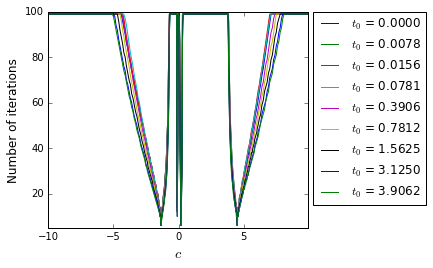

In [19]:
reload(bS)
dt = 5*4/2560.
t0 = 0.
t1 = 100.*dt
t2 = 200.*dt
test0 = bS.getTestResultVariableT0(allTests,t0)
test1 = bS.getTestResultVariableT0(allTests,t1)
test2 = bS.getTestResultVariableT0(allTests,t2)

bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test/testLabel")

['0.015625' '3.90625' '0.0' '0.0078125' '0.78125' '0.078125' '1.5625'
 '0.390625' '3.125']
t0 = 0.000000 --> min it = 7 for cL = cR = 0.195000 and error = 1.868908e-10
t0 = 0.007812 --> min it = 7 for cL = cR = 0.195000 and error = 2.280215e-10
t0 = 0.015625 --> min it = 7 for cL = cR = 0.195000 and error = 2.639817e-10
t0 = 0.078125 --> min it = 7 for cL = cR = 0.195000 and error = 1.890317e-10
t0 = 0.390625 --> min it = 7 for cL = cR = -1.340000 and error = 6.637804e-10
t0 = 0.781250 --> min it = 6 for cL = cR = -1.340000 and error = 8.108093e-10
t0 = 1.562500 --> min it = 6 for cL = cR = -1.345000 and error = 5.863618e-10
t0 = 3.125000 --> min it = 6 for cL = cR = -1.345000 and error = 2.406266e-10
t0 = 3.906250 --> min it = 6 for cL = cR = -1.345000 and error = 1.801162e-10
['0.015625' '3.90625' '0.0' '0.0078125' '0.78125' '0.078125' '1.5625'
 '0.390625' '3.125']
t0 = 0.000000 --> min it = 7 for cL = cR = 0.195000 and error = 1.868908e-10
t0 = 0.007812 --> min it = 7 for cL = cR = 

besseSchwarz.py:138: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(error),label="$c_L = %.3f$"%c,linestyle=next(linecycler), marker = next(markercycler))


['None', 'None', 'None', '+', '+', '+', 'o', 'o', 'o']
['None', 'None', 'None', '+', '+', '+', 'o', 'o', 'o']


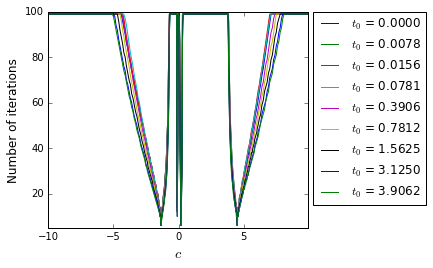

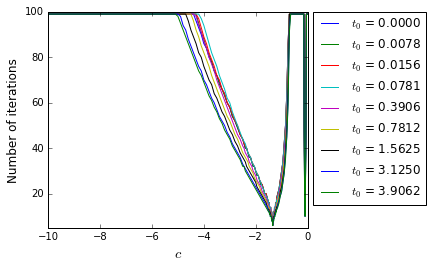

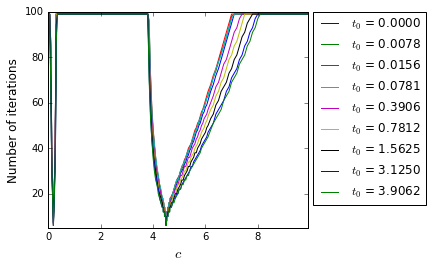

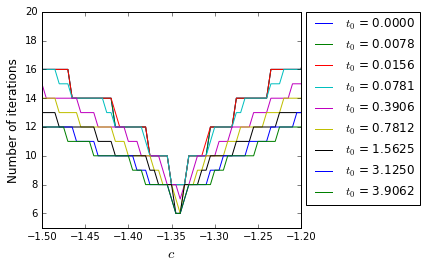

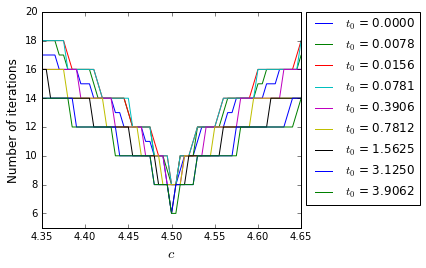

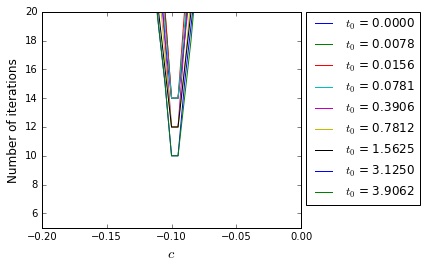

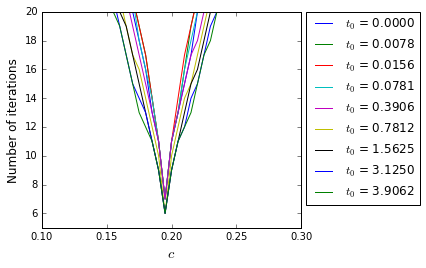

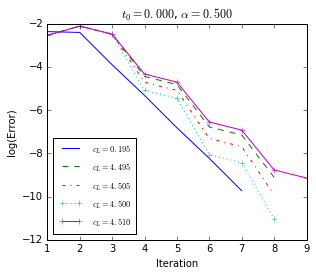

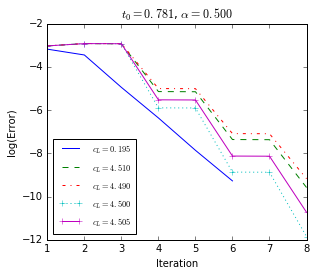

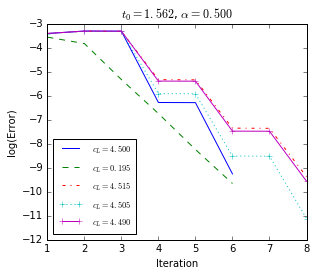

In [20]:
reload(bS)
dt = 5*4/2560.
t0 = 0.
t1 = 100.*dt
t2 = 200.*dt
test0 = bS.getTestResultVariableT0(allTests,t0)
test1 = bS.getTestResultVariableT0(allTests,t1)
test2 = bS.getTestResultVariableT0(allTests,t2)

bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersion")
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionN", xmax = 0.)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionP", xmin = 0.)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionNDetail", xmin = -1.5, xmax = -1.2,
                       ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionPDetail", xmin = 4.35, xmax = 4.65,
                      ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionNDetail2", xmin = -.2, xmax = 0.,
                       ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarT0FinalVersionPDetail2", xmin = .1, xmax = .3,
                      ymax = 20)
bS.plotErrorEvolution(test0,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t0,0.500),
                      savePath = "figures/test2/errorEvolutionFixedT0AFinalVersionOnlyPositive",rangeCoefs="positive")
bS.plotErrorEvolution(test1,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t1,0.500),
                      savePath = "figures/test2/errorEvolutionFixedT0BFinalVersionOnlyPositive",rangeCoefs="positive")
bS.plotErrorEvolution(test2,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t2,0.500),
                      savePath = "figures/test2/errorEvolutionFixedT0CFinalVersionOnlyPositive",rangeCoefs="positive")

['0.015625' '3.90625' '0.0' '0.0078125' '0.78125' '0.078125' '1.5625'
 '0.390625' '3.125']
t0 = 0.000000 --> min it = 7 for cL = cR = 0.195000 and error = 1.868908e-10
t0 = 0.007812 --> min it = 7 for cL = cR = 0.195000 and error = 2.280215e-10
t0 = 0.015625 --> min it = 7 for cL = cR = 0.195000 and error = 2.639817e-10
t0 = 0.078125 --> min it = 7 for cL = cR = 0.195000 and error = 1.890317e-10
t0 = 0.390625 --> min it = 7 for cL = cR = -1.340000 and error = 6.637804e-10
t0 = 0.781250 --> min it = 6 for cL = cR = -1.340000 and error = 8.108093e-10
t0 = 1.562500 --> min it = 6 for cL = cR = -1.345000 and error = 5.863618e-10
t0 = 3.125000 --> min it = 6 for cL = cR = -1.345000 and error = 2.406266e-10
t0 = 3.906250 --> min it = 6 for cL = cR = -1.345000 and error = 1.801162e-10
['0.015625' '3.90625' '0.0' '0.0078125' '0.78125' '0.078125' '1.5625'
 '0.390625' '3.125']
t0 = 0.000000 --> min it = 7 for cL = cR = 0.195000 and error = 1.868908e-10
t0 = 0.007812 --> min it = 7 for cL = cR = 

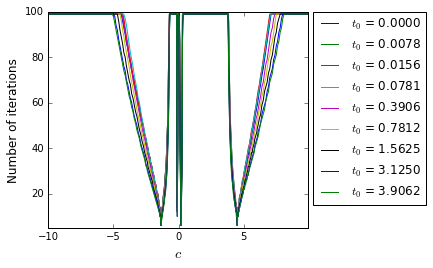

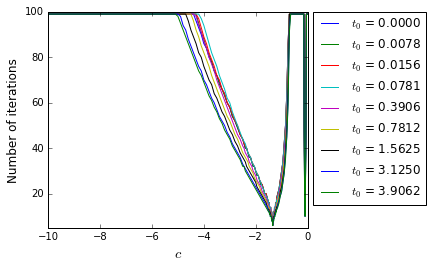

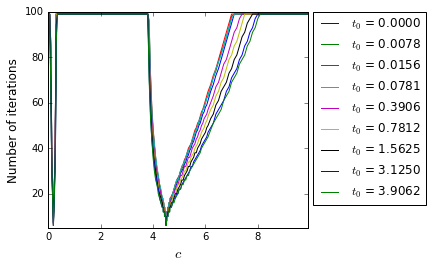

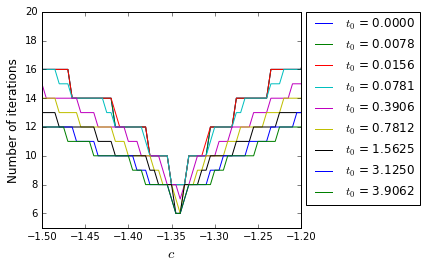

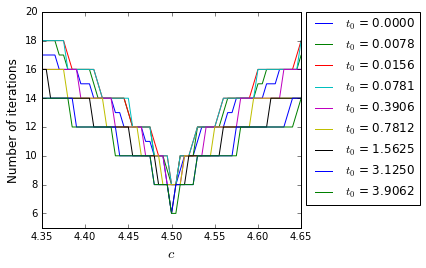

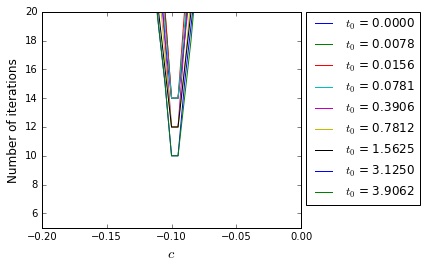

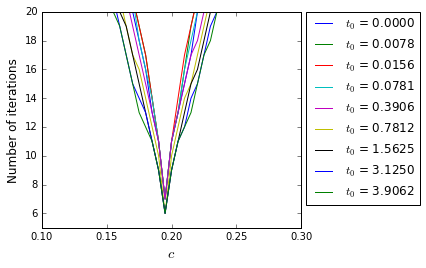

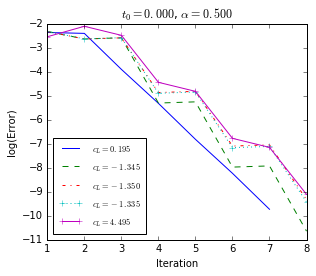

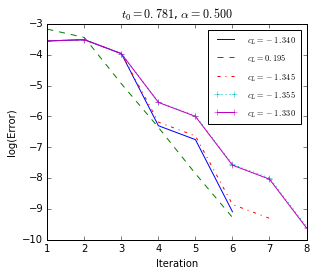

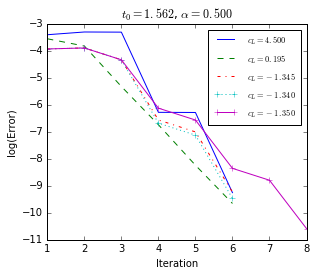

In [17]:
reload(bS)

t0 = 0.
t1 = 100.*dt
t2 = 200.*dt
test0 = bS.getTestResultVariableT0(allTests,t0)
test1 = bS.getTestResultVariableT0(allTests,t1)
test2 = bS.getTestResultVariableT0(allTests,t2)

bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersion")
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionN", xmax = 0.)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionP", xmin = 0.)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionNDetail", xmin = -1.5, xmax = -1.2,
                       ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionPDetail", xmin = 4.35, xmax = 4.65,
                      ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionNDetail2", xmin = -.2, xmax = 0.,
                       ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/TBCbesse/NiterxCoefVarT0FinalVersionPDetail2", xmin = .1, xmax = .3,
                      ymax = 20)
bS.plotErrorEvolution(test0,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t0,0.500),
                      savePath = "figures/TBCbesse/errorEvolutionFixedT0AFinalVersion")
bS.plotErrorEvolution(test1,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t1,0.500),
                      savePath = "figures/TBCbesse/errorEvolutionFixedT0BFinalVersion")
bS.plotErrorEvolution(test2,5,titleCompl=r'$t_0 = %.3f$, $\alpha = %.3f$'%(t2,0.500),
                      savePath = "figures/TBCbesse/errorEvolutionFixedT0CFinalVersion")

# Tests with different positions of the interface

We want now to check the robustness of the coefficients regarding the position of the interface, i.e., the domain decomposition considered. In all the tests done above, we decomposed $\Omega$ in two domains of same size. Now, always considering the domain $\Omega = [-L,L]$, we will consider different partitions of the domain :

$$\Omega_1 = [-L,-L+2L\alpha ] \\
  \Omega_2 = [-L+2L\alpha ,L]$$
  
with  a variable $\alpha \in (0,1)$ . 

In [61]:
reload(bS)
reload(besseTBC)

Interfaces = np.arange(0.1,1.0,0.1)
cLs = np.arange(-2.25,2.25,0.05)
cLs = np.arange(-10.0,10.0,0.1)
#cRs = np.arange(-2.25,2.25,0.25)
#cLs = np.arange(0.0,0.6,0.05)
#cLs = np.arange(0.10,0.21,0.01)
detailcLs1 = np.append(np.arange(-1.5,-1.19,0.005),np.arange(4.35,4.66,0.005))
detailcLs1 = np.append(np.arange(-0.2,0.,0.005),np.arange(0.1,0.3,0.005))
cLs = np.append(cLs,detailcLs1)
cRs = np.copy(cLs)

cL = .25
cR = .25

computeExactSolution = False

L = 6.
xmin = -L
xmax = L
N = 501
U2 = 1.

dt = 5*4/2560.

t0 = 100.*dt
tmax = t0+dt

dx = (xmax-xmin)/N
x = np.linspace(xmin,xmax,N)

dx = np.diff(x)[0]

filename = 'speedTestsVariableInterfaceFinalVersion.json'
testsSpeedDiffInterface = besseTBC.loadTests(filename)
 
u = besseTBC.exactSolution(x,t0,besseTBC.initGauss)


for interface in Interfaces :

    print(interface)
    
    lim = int(x.size*interface)
    x1 = x[0:lim+1]
    x2 = x[lim:]

    print(x1.size)
    print(x2.size)


    if str(interface) in testsSpeedDiffInterface.keys() :
        tests = testsSpeedDiffInterface[str(interface)]
    else :
        tests = {}

    coefTBC = np.zeros((1,2))
    uallref,tallref = besseTBC.runDispKdV(x,u,t0,tmax,1., coefTBC , periodic = 0, vardt = False, dt = dt,
                                           order = 0, modifyDiscret = 1, middlePoint = lim+1,
                                           useTBCL = False, useTBCR = False)    
        
        
    tests = bS.optimizeSpeed(x,x1,x2,u,uallref,cLs,cRs,tests,t0,tmax,dx,dt,maxiter = 100,equalCoef=True,
                             middlePoint = lim+1, criteria = "error",epsCV=1e-9, modifyDiscret=0)
    
    testsSpeedDiffInterface[str(interface)] = tests

besseTBC.saveTests(testsSpeedDiffInterface,filename)

0.1
51
451

*** Computing solution ...
*** End of computation ***

*** Computing solution ...
*** End of computation ***
(-0.19500000000000001, -0.19500000000000001, 99, 657365.35453003598)

*** Computing solution ...
*** End of computation ***
(-0.19, -0.19, 99, 140694.30714558836)

*** Computing solution ...
*** End of computation ***
(-0.185, -0.185, 99, 24921.240745760348)

*** Computing solution ...
*** End of computation ***
(-0.17999999999999999, -0.17999999999999999, 99, 3578.3327892684133)

*** Computing solution ...
*** End of computation ***
(-0.17499999999999999, -0.17499999999999999, 99, 406.6443828229194)

*** Computing solution ...
*** End of computation ***
(-0.16999999999999998, -0.16999999999999998, 99, 35.568284972169856)

*** Computing solution ...
*** End of computation ***
(-0.16499999999999998, -0.16499999999999998, 99, 2.317256487133077)

*** Computing solution ...
*** End of computation ***
(-0.15999999999999998, -0.15999999999999998, 99, 0.10813872641407428)



In [21]:
reload(bS)

filename = 'speedTestsVariableInterfaceFinalVersion.json'
allTests = besseTBC.loadTests(filename)

In [62]:
allTests = testsSpeedDiffInterface

['0.9' '0.8' '0.1' '0.3' '0.2' '0.5' '0.4' '0.7' '0.6']
t0 = 0.100000 --> min it = 7 for cL = cR = -1.345000 and error = 9.028869e-10
t0 = 0.200000 --> min it = 7 for cL = cR = 0.195000 and error = 6.070835e-11
t0 = 0.300000 --> min it = 6 for cL = cR = 0.195000 and error = 8.935336e-10
t0 = 0.400000 --> min it = 6 for cL = cR = -1.340000 and error = 8.140435e-10
t0 = 0.500000 --> min it = 6 for cL = cR = -1.340000 and error = 8.108069e-10
t0 = 0.600000 --> min it = 6 for cL = cR = -1.345000 and error = 2.215313e-10
t0 = 0.700000 --> min it = 6 for cL = cR = -1.345000 and error = 2.354445e-10
t0 = 0.800000 --> min it = 6 for cL = cR = -1.345000 and error = 1.804002e-10
t0 = 0.900000 --> min it = 5 for cL = cR = 0.195000 and error = 8.699306e-10
['0.9' '0.8' '0.1' '0.3' '0.2' '0.5' '0.4' '0.7' '0.6']
t0 = 0.100000 --> min it = 7 for cL = cR = -1.345000 and error = 9.028869e-10
t0 = 0.200000 --> min it = 7 for cL = cR = 0.195000 and error = 6.070835e-11
t0 = 0.300000 --> min it = 6 for c

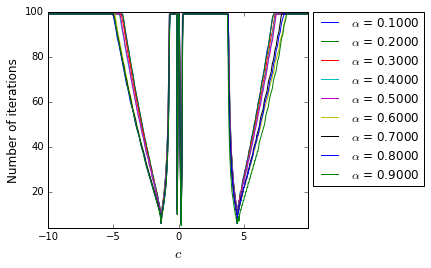

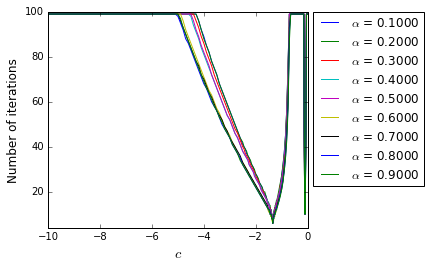

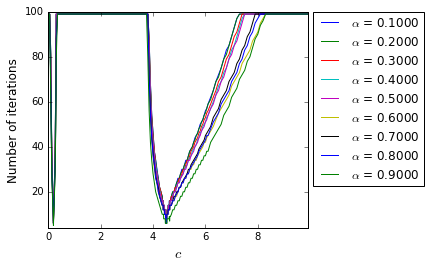

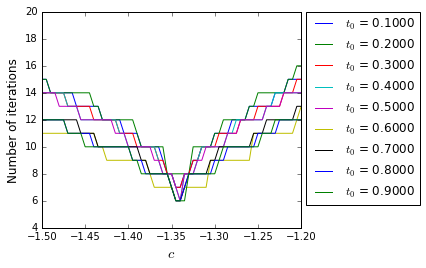

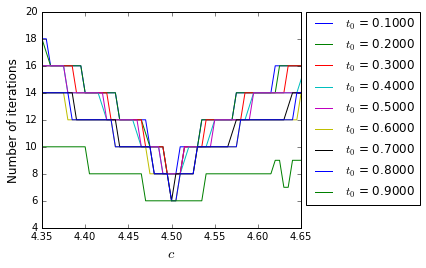

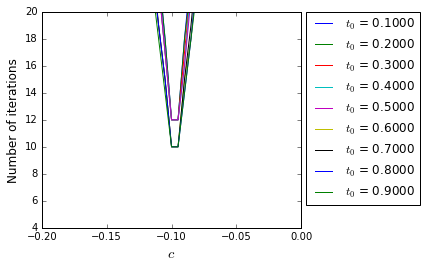

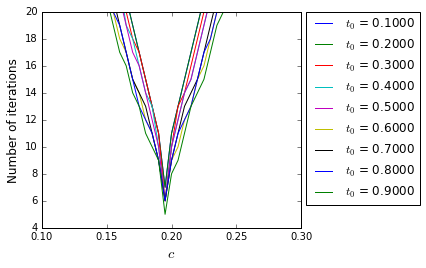

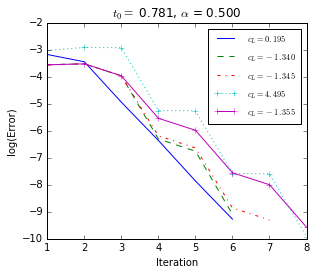

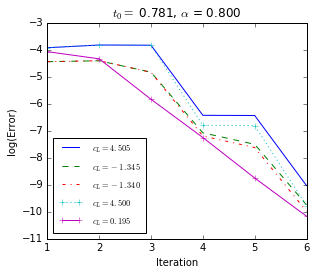

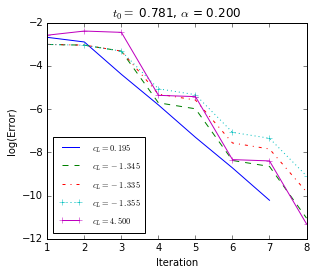

In [22]:
reload(bS)

t0 = 100.*dt

alpha1 = .5
alpha2 = .8
alpha3 = .2
test1 = bS.getTestResultVariableT0(allTests,alpha1)
test2 = bS.getTestResultVariableT0(allTests,alpha2)
test3 = bS.getTestResultVariableT0(allTests,alpha3)
bS.plotIterationsxCoef(allTests,r"$\alpha$",titleCompl = "Variable interface",legloc=(1.1,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersion")
bS.plotIterationsxCoef(allTests,r"$\alpha$",titleCompl = "Variable interface",legloc=(1.1,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionN", xmax = 0)
bS.plotIterationsxCoef(allTests,r"$\alpha$",titleCompl = "Variable interface",legloc=(1.1,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionP", xmin = 0)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionNDetail",
                       xmin = -1.5, xmax = -1.2, ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionPDetail",
                       xmin = 4.35, xmax = 4.65, ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionNDetail2",
                       xmin = -0.2, xmax = 0., ymax = 20)
bS.plotIterationsxCoef(allTests,r"$t_0$",titleCompl = "Variable t0",legloc=(1.05,0.),
                       savePath="figures/test2/NiterxCoefVarInterfaceFinalVersionPDetail2",
                       xmin = 0.1, xmax = 0.3, ymax = 20)
bS.plotErrorEvolution(test1,5,titleCompl=r'$t_0 = $ %.3f, $\alpha$ = %.3f'%(t0,alpha1),
                      savePath = "figures/test2/errorEvolutionFixedInterfaceAFinalVersion")
bS.plotErrorEvolution(test2,5,titleCompl=r'$t_0 = $ %.3f, $\alpha$ = %.3f'%(t0,alpha2),
                      savePath = "figures/test2/errorEvolutionFixedInterfaceBFinalVersion")
bS.plotErrorEvolution(test3,5,titleCompl=r'$t_0 = $ %.3f, $\alpha$ = %.3f'%(t0,alpha3),
                      savePath = "figures/test2/errorEvolutionFixedInterfaceCFinalVersion")

# Some tests with different $dx,dt$

# Tests with MSM

t0 = 0.015625 --> min it = 6 for cL = cR = 0.200000 and error = 6.918844e-10
t0 = 3.906250 --> min it = 5 for cL = cR = 0.200000 and error = 1.895634e-10
t0 = 0.000000 --> min it = 6 for cL = cR = 0.200000 and error = 7.268261e-10
t0 = 0.007812 --> min it = 6 for cL = cR = 0.200000 and error = 7.208827e-10
t0 = 0.781250 --> min it = 6 for cL = cR = 0.200000 and error = 6.243286e-11
t0 = 0.078125 --> min it = 6 for cL = cR = 0.200000 and error = 4.918851e-10
t0 = 1.562500 --> min it = 5 for cL = cR = 0.200000 and error = 6.257464e-10
t0 = 0.390625 --> min it = 6 for cL = cR = 0.200000 and error = 1.402197e-10
t0 = 3.125000 --> min it = 5 for cL = cR = 0.200000 and error = 2.538878e-10


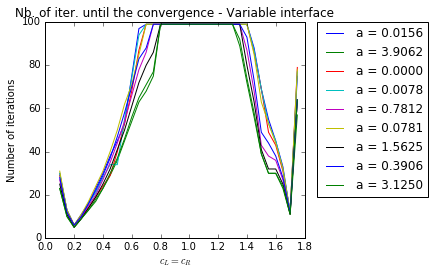

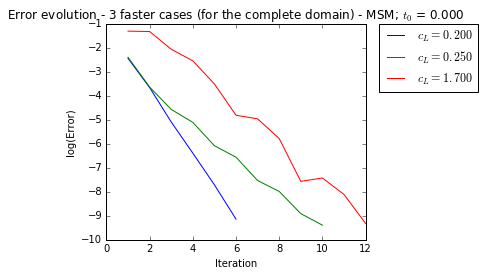

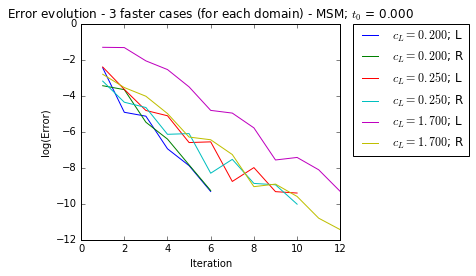

In [32]:
reload(bS)

filename = 'testMSM.json'
allTests = besseTBC.loadTests(filename)

t0 = 0.
test0 = bS.getTestResultVariableT0(allTests,t0)
bS.plotIterationsxCoef(allTests,"a",titleCompl = "Variable interface",legloc=(1.1,0.), savePath="figures/DDM/debug/MSMniter")
bS.plotErrorEvolution(test0,3,titleCompl=r'MSM; $t_0$ = %.3f'%t0, legloc=(1.1,0.), savePath="figures/DDM/debug/MSMerror")

# Tests with MSMi

t0 = 0.015625 --> min it = 8 for cL = cR = 0.200000 and error = 1.973917e-10
t0 = 3.906250 --> min it = 6 for cL = cR = 0.200000 and error = 1.722894e-10
t0 = 0.000000 --> min it = 8 for cL = cR = 0.200000 and error = 2.240531e-10
t0 = 0.007812 --> min it = 8 for cL = cR = 0.200000 and error = 2.143907e-10
t0 = 0.781250 --> min it = 7 for cL = cR = 0.200000 and error = 9.270284e-11
t0 = 0.078125 --> min it = 8 for cL = cR = 0.200000 and error = 8.241975e-11
t0 = 1.562500 --> min it = 6 for cL = cR = 0.200000 and error = 5.346988e-10
t0 = 0.390625 --> min it = 7 for cL = cR = 0.200000 and error = 2.131551e-10
t0 = 3.125000 --> min it = 6 for cL = cR = 0.200000 and error = 2.272703e-10


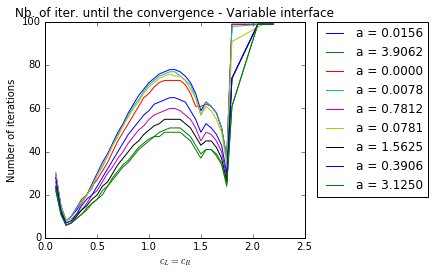

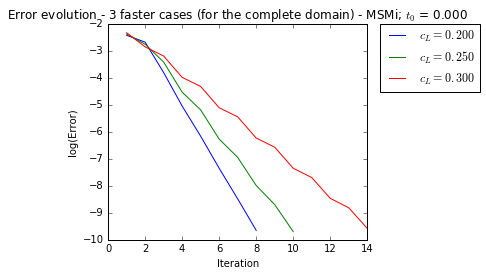

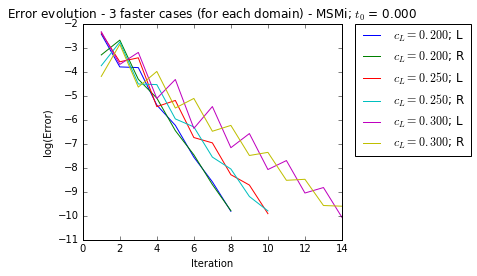

In [34]:
reload(bS)

filename = 'testMSMi.json'
allTests = besseTBC.loadTests(filename)

t0 = 0.
test0 = bS.getTestResultVariableT0(allTests,t0)
bS.plotIterationsxCoef(allTests,"a",titleCompl = "Variable interface",legloc=(1.1,0.), savePath="figures/DDM/debug/iMSMniter")
bS.plotErrorEvolution(test0,3,titleCompl=r'MSMi; $t_0$ = %.3f'%t0, legloc=(1.1,0.), savePath="figures/DDM/debug/iMSMerror")